In [367]:
import pandas as pd
import glob
import numpy as numpy
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Read in data


In [415]:
dict_of_stocks_and_dfs = {}
for file_ in glob.glob('../data/updated_historical_stock_data/*.csv'):
    stock_name = file_.rsplit("/")[-1].split('_')[0].lower() 
    print(f"Reading in {stock_name}")
    dict_of_stocks_and_dfs[stock_name] = pd.read_csv(f"{file_}")


Reading in pnr
Reading in bac
Reading in ni
Reading in vno
Reading in ual
Reading in efx
Reading in ph
Reading in rop
Reading in are
Reading in pg
Reading in pvh
Reading in lb
Reading in cern
Reading in peg
Reading in adbe
Reading in emr
Reading in ce
Reading in eqix
Reading in rost
Reading in so


In [416]:
# key is company value is df of data
dict_of_stocks_and_dfs.keys()

dict_keys(['pnr', 'bac', 'ni', 'vno', 'ual', 'efx', 'ph', 'rop', 'are', 'pg', 'pvh', 'lb', 'cern', 'peg', 'adbe', 'emr', 'ce', 'eqix', 'rost', 'so'])

# Create correlation & variance features
- Daily, weekly, 30-days, 90-days, 180-days, 365-days

In [417]:

# here the date is not the index, yet
first_stock_df = dict_of_stocks_and_dfs['ph'].loc[ dict_of_stocks_and_dfs['ph'].date.isin(dict_of_stocks_and_dfs['emr'].date), :]

In [418]:
np.var(first_stock_df.close)

2858.765436116092

In [419]:
dict_of_stocks_and_dfs['ph'][dict_of_stocks_and_dfs['ph'].date == '2017-01-02']

,Unnamed: 0,date,open,high,low,close,volume


In [420]:
dict_of_stocks_and_dfs['ph'][dict_of_stocks_and_dfs['ph'].date == '2017-01-03']

,Unnamed: 0,date,open,high,low,close,volume
0,0,2017-01-03,142.20,144.25,140.83,142.55,1115090
8770,7942,2017-01-03,139.89,141.90,138.54,140.23,1133527


In [421]:
dict_of_stocks_and_dfs['ph'][dict_of_stocks_and_dfs['ph'].date == '2017-01-04']

,Unnamed: 0,date,open,high,low,close,volume
1,1,2017-01-04,142.50,143.20,141.90,142.64,637928
8771,7943,2017-01-04,140.18,140.88,139.59,140.32,648476


In [410]:
dict_of_stocks_and_dfs['ph'][dict_of_stocks_and_dfs['ph'].date == '2017-01-05']

,date,open,high,low,close,volume
2,2017-01-05,142.35,142.67,139.92,141.37,557915
8772,2017-01-05,140.04,140.35,137.65,139.07,567140


In [411]:
dict_of_stocks_and_dfs['ph'][dict_of_stocks_and_dfs['ph'].date == '2017-01-06']

,date,open,high,low,close,volume
3,2017-01-06,141.91,142.40,141.06,141.49,727481
8773,2017-01-06,139.60,140.08,138.76,139.19,739501


In [414]:
dict_of_stocks_and_dfs['ph'][dict_of_stocks_and_dfs['ph'].date == '2018-01-08']

,date,open,high,low,close,volume
255,2018-01-08,203.81,206.41,203.67,205.55,974719


In [ ]:
2017-01-04

In [6]:

# here the date is not the index, yet
first_stock_df = dict_of_stocks_and_dfs['ph'].loc[ dict_of_stocks_and_dfs['ph'].date.isin(dict_of_stocks_and_dfs['emr'].date), :]
#  filter second df by the dates in first

# here the date is not the index, yet
second_stock_df = dict_of_stocks_and_dfs['emr'].loc[ dict_of_stocks_and_dfs['emr'].date.isin(dict_of_stocks_and_dfs['ph'].date), :]

## Set the date as the index and sort

In [7]:
first_stock_df = first_stock_df.sort_values('date')
second_stock_df = second_stock_df.sort_values('date')

first_stock_df = first_stock_df.set_index('date')
second_stock_df = second_stock_df.set_index('date')

In [8]:
first_stock_df.index.max()

'2020-04-17'

In [9]:
second_stock_df.index.max()

'2020-04-17'

In [10]:
np.corrcoef(first_stock_df.close, second_stock_df.close) # all time corrcoef

array([[1.        , 0.95353675],
       [0.95353675, 1.        ]])

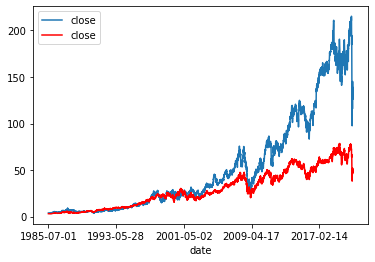

In [11]:

ax = first_stock_df.plot(y='close')
second_stock_df.plot(y='close', color='red', ax=ax)

In [12]:
n_rows = len(first_stock_df)
n_days_stride = 365

previous_row = 0
c = 0

correlation_per_time_period = defaultdict(list)
for day_window in range(n_rows):
    
    if day_window % 100 == 0:
        print(f"Idx {day_window} out of {n_rows}")
    first_stock= first_stock_df.iloc[previous_row:day_window + n_days_stride, :]
    second_stock = second_stock_df.iloc[previous_row:day_window + n_days_stride, :]
#     print(f"Correcoef for {first_stock.index.min()} to {second_stock.index.max()}")
    correlation = np.corrcoef(first_stock.close, second_stock.close)[0,1]

#     print(correlation) 
    
    correlation_per_time_period['date'].append(first_stock.index.min())
    correlation_per_time_period['correlation'].append(correlation)
    
    previous_row+= 1

    
    

Idx 0 out of 8988
Idx 100 out of 8988
Idx 200 out of 8988
Idx 300 out of 8988
Idx 400 out of 8988
Idx 500 out of 8988
Idx 600 out of 8988
Idx 700 out of 8988
Idx 800 out of 8988
Idx 900 out of 8988
Idx 1000 out of 8988
Idx 1100 out of 8988
Idx 1200 out of 8988
Idx 1300 out of 8988
Idx 1400 out of 8988
Idx 1500 out of 8988
Idx 1600 out of 8988
Idx 1700 out of 8988
Idx 1800 out of 8988
Idx 1900 out of 8988
Idx 2000 out of 8988
Idx 2100 out of 8988
Idx 2200 out of 8988
Idx 2300 out of 8988
Idx 2400 out of 8988
Idx 2500 out of 8988
Idx 2600 out of 8988
Idx 2700 out of 8988
Idx 2800 out of 8988
Idx 2900 out of 8988
Idx 3000 out of 8988
Idx 3100 out of 8988
Idx 3200 out of 8988
Idx 3300 out of 8988
Idx 3400 out of 8988
Idx 3500 out of 8988
Idx 3600 out of 8988
Idx 3700 out of 8988
Idx 3800 out of 8988
Idx 3900 out of 8988
Idx 4000 out of 8988
Idx 4100 out of 8988
Idx 4200 out of 8988
Idx 4300 out of 8988
Idx 4400 out of 8988
Idx 4500 out of 8988
Idx 4600 out of 8988
Idx 4700 out of 8988
Idx 

/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [15]:
correlation_df = pd.DataFrame(correlation_per_time_period)
correlation_df.set_index('date')

,correlation
date,
1985-07-01,0.908957
1985-07-02,0.908344
1985-07-03,0.908069
1985-07-05,0.907743
1985-07-08,0.907586
...,...
2020-04-13,0.936544
2020-04-14,0.965812
2020-04-15,0.970104


In [16]:
correlation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8988 entries, 0 to 8987
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         8988 non-null   object 
 1   correlation  8987 non-null   float64
dtypes: float64(1), object(1)
memory usage: 140.6+ KB


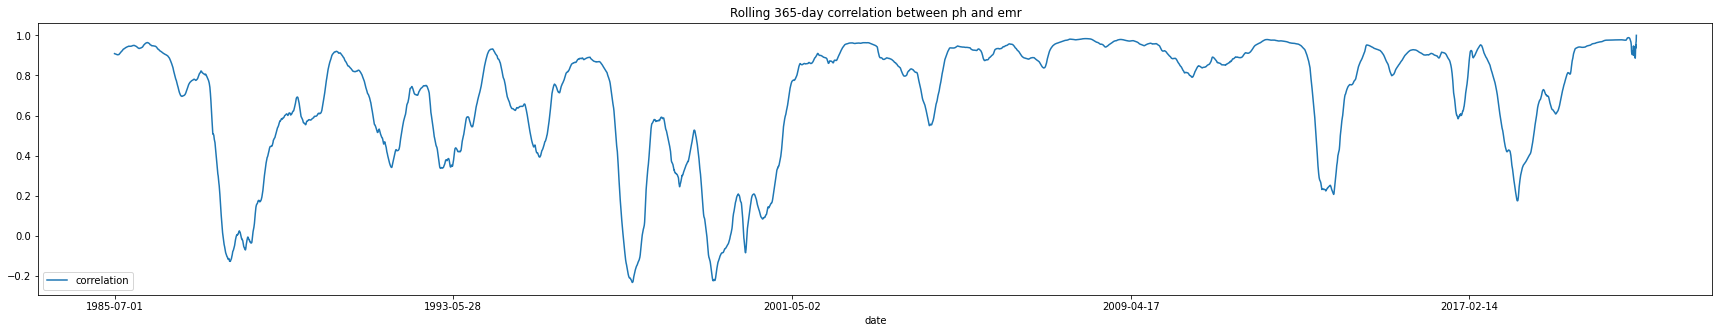

In [17]:
correlation_df.set_index('date').plot(figsize=(30,5), title='Rolling 365-day correlation between ph and emr')

In [19]:
correlation_df.date.max()

'2020-04-17'

In [60]:
correlation_df.rolling(7).sum()

,correlation
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
8983,6.469109
8984,6.508580
8985,6.539512
8986,6.653166


In [21]:
correlation_df

,date,correlation
0,1985-07-01,0.908957
1,1985-07-02,0.908344
2,1985-07-03,0.908069
3,1985-07-05,0.907743
4,1985-07-08,0.907586
...,...,...
8983,2020-04-13,0.936544
8984,2020-04-14,0.965812
8985,2020-04-15,0.970104
8986,2020-04-16,1.000000


## Build a function to create correlation features for all pairs of stocks

In [319]:
def build_correlation_dfs(dict_of_stocks_and_dfs, n_day_rolling_features_list=[ 3, 7, 30, 180, 365, 720]):
    """
    Create correlation + variance based  upon daily closing stock prices for given date ranges 3, 7, 30, 180, 365 days
    
    also include daily volume
    
    We are trying to  predict 7 day correaltion
    """

    stock_features_dict = defaultdict(pd.DataFrame)
    start_time = time.time()
    
    start = time.time()
    n_stocks = len(dict_of_stocks_and_dfs.keys())
    final_feature_df = create_date_dummy_df()
    
    for idx, first_stock_name in enumerate(dict_of_stocks_and_dfs.keys()):
        print('')
        print(f"Finished {idx/n_stocks} pct of stocks")
        print('')
        for second_idx, second_stock_name in enumerate(dict_of_stocks_and_dfs.keys()):
            if first_stock_name == second_stock_name:
                continue
            print('-------')
            print(f"{first_stock_name} & {second_stock_name}")
            print('-------')
            
            # here the date is not the index, yet
            first_stock_df = dict_of_stocks_and_dfs[f"{first_stock_name}"].loc[ 
                dict_of_stocks_and_dfs[f"{first_stock_name}"].date.isin(dict_of_stocks_and_dfs[f"{second_stock_name}"].date), :]
#             first_stock_df.date = pd.to_datetime(first_stock_df)
            #  filter second df by the dates in first

            # here the date is not the index, yet
            second_stock_df = dict_of_stocks_and_dfs[f"{second_stock_name}"].loc[ 
                dict_of_stocks_and_dfs[f"{second_stock_name}"].date.isin(dict_of_stocks_and_dfs[f"{first_stock_name}"].date), :]
#             second_stock_df.date = pd.to_datetime(second_stock_df)

            # set the date as an index and sort by date
            first_stock_df = first_stock_df.sort_values('date')
            second_stock_df = second_stock_df.sort_values('date')

            first_stock_df = first_stock_df.set_index('date')
            second_stock_df = second_stock_df.set_index('date')
            
            all_features_df = pd.DataFrame()
            for rolling_idx, rolling_day in enumerate(n_day_rolling_features_list):
                print('rolling_idx', rolling_idx)
                features_df = create_correlation_and_variance_features(
                    first_stock_df, second_stock_df, rolling_day, first_stock_name=first_stock_name, second_stock_name=second_stock_name)
                 
#                 if rolling_idx == 0: # only add in volume features once
#                 if f"{first_stock_name}_volume" in    

                if (f"{first_stock_name}_volume" not in features_df.columns) and (rolling_idx == 0):
                    print('adding first stock volume')
                    features_df[f"{first_stock_name}_volume"] = list(first_stock_df.volume)
                
                if (f"{second_stock_name}_volume" not in features_df.columns) and (rolling_idx == 0):
                    print('adding second stock volume')
                    features_df[f"{second_stock_name}_volume"] = list(second_stock_df.volume)
                    
                if rolling_idx == 0: 
                    print('features_df', features_df.head())
                    print('rolling idx == 0')
                    all_features_df = features_df
                else:
                    print(all_features_df.info(), 'alal features')
                    print(features_df.info(), 'features_df df')
                    all_features_df = all_features_df.join(features_df.set_index('date'), on='date', lsuffix='_left')
                    
            all_features_df.date = pd.to_datetime(all_features_df.date)
            final_feature_df = final_feature_df.join(all_features_df.set_index('date'), on='date')
            print('all_features_df', all_features_df.head())

#                     final_df.join(all_features_df)
        
            stock_features_dict[f"{first_stock_name}_and_{second_stock_name}"] = all_features_df
            
            end = time.time()
            print(f"Building all correlations took {(end-start)/60} minutes")
            start = time.time()
            break
        
        break

    end_time = time.time()
    print(f"Total time {(end_time-start_time) / 60} minutes")
    return final_feature_df
            
        

# Note: will eventuall need to add in 0s for stocks withour correlation data with other stocks due to date range

In [320]:
def create_date_dummy_df(start_date=datetime.datetime(1980,1,1), n_years=55):
    
    #  create dummy df with dates to join against
    list_of_dates  = []
    n_days = 365*n_years
    start_date = datetime.datetime(1970,1,1)

    for i in range(n_days):
        list_of_dates.append(start_date + datetime.timedelta(i))
    df_ = pd.DataFrame(list_of_dates, columns=['date'])
    
    df_.date_ =  pd.to_datetime(df_.date)
    return df_.set_index('date')
    

In [321]:
def create_correlation_and_variance_features(first_stock_df, second_stock_df, n_days_stride, 
                                             first_stock_name=None, second_stock_name=None):
    """
    n_days_stride: the  number of rolling days to calculate correlation for
    """
    n_rows = len(first_stock_df)

    previous_row = 0

    features_per_time_period = defaultdict(list)
    print(f"Creating correlations + variance on close for {n_days_stride} days")
    
    for day_window in tqdm(range(n_rows)):


        first_stock= first_stock_df.iloc[previous_row:day_window + n_days_stride, :]

        second_stock = second_stock_df.iloc[previous_row:day_window + n_days_stride, :]
        
        try:
            correlation = np.corrcoef(first_stock.close, second_stock.close)[0,1]
        except Exception as e:
            print(f" ERROR: {e}")

        features_per_time_period['date'].append(first_stock.index.min())

        features_per_time_period[f"{first_stock_name}_{second_stock_name}_corr_rolling_{n_days_stride}_days"].append(correlation)
        # CODE TO ADD IN VARIANCE
#         first_stock_var = np.var(first_stock.close)
#         second_stock_var = np.var(second_stock.close)
        
#         features_per_time_period[f"{first_stock_name}_close_var_rolling_{n_days_stride}_days"].append(first_stock_var)
#         features_per_time_period[f"{second_stock_name}_close_var_rolling_{n_days_stride}_days"].append(second_stock_var)
    
        
        previous_row+= 1 # calculate snapshots every day...7/1-7/7, 7/2-7/8, ...etc
    
    print('Finished feature calculation')
    features_per_time_period_df = pd.DataFrame(features_per_time_period)
    features_per_time_period_df.set_index('date')
    
    return features_per_time_period_df


In [314]:
# 100 minutes for 20 stocks (20*20 = 400 pairs each pair takes .25 minutes)
final_stock_df = build_correlation_dfs(dict_of_stocks_and_dfs)

/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  if sys.path[0] == '':
  3%|▎         | 115/4029 [00:00<00:03, 1144.83it/s]


Finished 0.0 pct of stocks

-------
pnr & bac
-------
rolling_idx 0
Creating correlations + variance on close for 3 days


100%|█████████▉| 4009/4029 [00:02<00:00, 1536.12it/s]/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
  4%|▎         | 142/4029 [00:00<00:02, 1416.18it/s]

Finished feature calculation
adding first stock volume
adding second stock volume
features_df          date  pnr_bac_corr_rolling_3_days  pnr_volume  bac_volume
0  2005-02-25                    -0.978919      425379     8656470
1  2005-02-28                    -0.985118      489224    10653157
2  2005-03-01                    -0.998760      479025    11230182
3  2005-03-02                     0.704533      458965    10294635
4  2005-03-03                     0.538977      589176     9655981
rolling idx == 0
rolling_idx 1
Creating correlations + variance on close for 7 days


 99%|█████████▉| 3982/4029 [00:02<00:00, 1541.27it/s]/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
  4%|▍         | 154/4029 [00:00<00:02, 1537.46it/s]

Finished feature calculation
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4029 entries, 0 to 4028
Data columns (total 4 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   date                         4029 non-null   object 
 1   pnr_bac_corr_rolling_3_days  4027 non-null   float64
 2   pnr_volume                   4029 non-null   int64  
 3   bac_volume                   4029 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 126.0+ KB
None alal features
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4029 entries, 0 to 4028
Data columns (total 2 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   date                         4029 non-null   object 
 1   pnr_bac_corr_rolling_7_days  4028 non-null   float64
dtypes: float64(1), object(1)
memory usage: 63.1+ KB
None features_df df
rolling_idx 2
Creating 

  3%|▎         | 141/4029 [00:00<00:02, 1409.73it/s]

Finished feature calculation
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4465 entries, 0 to 4028
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   date                         4465 non-null   object 
 1   pnr_bac_corr_rolling_3_days  4463 non-null   float64
 2   pnr_volume                   4465 non-null   int64  
 3   bac_volume                   4465 non-null   int64  
 4   pnr_bac_corr_rolling_7_days  4464 non-null   float64
dtypes: float64(2), int64(2), object(1)
memory usage: 209.3+ KB
None alal features
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4029 entries, 0 to 4028
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   date                          4029 non-null   object 
 1   pnr_bac_corr_rolling_30_days  4028 non-null   float64
dtypes: float64(1), object(1)
memo

  4%|▎         | 145/4029 [00:00<00:02, 1449.43it/s]

Finished feature calculation
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5337 entries, 0 to 4028
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   date                          5337 non-null   object 
 1   pnr_bac_corr_rolling_3_days   5335 non-null   float64
 2   pnr_volume                    5337 non-null   int64  
 3   bac_volume                    5337 non-null   int64  
 4   pnr_bac_corr_rolling_7_days   5336 non-null   float64
 5   pnr_bac_corr_rolling_30_days  5336 non-null   float64
dtypes: float64(3), int64(2), object(1)
memory usage: 291.9+ KB
None alal features
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4029 entries, 0 to 4028
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   date                           4029 non-null   object 
 1   pnr_bac_corr_rollin

  4%|▎         | 143/4029 [00:00<00:02, 1425.78it/s]

Finished feature calculation
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7081 entries, 0 to 4028
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   date                           7081 non-null   object 
 1   pnr_bac_corr_rolling_3_days    7079 non-null   float64
 2   pnr_volume                     7081 non-null   int64  
 3   bac_volume                     7081 non-null   int64  
 4   pnr_bac_corr_rolling_7_days    7080 non-null   float64
 5   pnr_bac_corr_rolling_30_days   7080 non-null   float64
 6   pnr_bac_corr_rolling_180_days  7080 non-null   float64
dtypes: float64(4), int64(2), object(1)
memory usage: 442.6+ KB
None alal features
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4029 entries, 0 to 4028
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   date       

100%|██████████| 4029/4029 [00:02<00:00, 1413.16it/s]

Finished feature calculation
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10569 entries, 0 to 4028
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   date                           10569 non-null  object 
 1   pnr_bac_corr_rolling_3_days    10567 non-null  float64
 2   pnr_volume                     10569 non-null  int64  
 3   bac_volume                     10569 non-null  int64  
 4   pnr_bac_corr_rolling_7_days    10568 non-null  float64
 5   pnr_bac_corr_rolling_30_days   10568 non-null  float64
 6   pnr_bac_corr_rolling_180_days  10568 non-null  float64
 7   pnr_bac_corr_rolling_365_days  10568 non-null  float64
dtypes: float64(5), int64(2), object(1)
memory usage: 743.1+ KB
None alal features
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4029 entries, 0 to 4028
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------    

In [330]:
final_stock_df.loc[~pd.isna(final_stock_df.pnr_volume), :]

,pnr_bac_corr_rolling_3_days,pnr_volume,bac_volume,pnr_bac_corr_rolling_7_days,pnr_bac_corr_rolling_30_days,pnr_bac_corr_rolling_180_days,pnr_bac_corr_rolling_365_days,pnr_bac_corr_rolling_720_days
date,,,,,,,,
2005-02-25,-0.978919,425379.0,8656470.0,-0.449730,0.941902,0.758490,-0.298009,-0.619574
2005-02-28,-0.985118,489224.0,10653157.0,-0.366235,0.944691,0.750536,-0.312585,-0.615585
2005-03-01,-0.998760,479025.0,11230182.0,0.067429,0.942435,0.742085,-0.326191,-0.608959
2005-03-02,0.704533,458965.0,10294635.0,0.706662,0.957729,0.734868,-0.338970,-0.601874
2005-03-03,0.538977,589176.0,9655981.0,0.896342,0.943357,0.729266,-0.350936,-0.595477
...,...,...,...,...,...,...,...,...
2020-04-13,0.669138,806105.0,83164717.0,0.871451,0.871451,0.871451,0.871451,0.871451
2020-04-14,0.999157,1355716.0,88991066.0,0.989073,0.989073,0.989073,0.989073,0.989073
2020-04-15,0.989084,2278293.0,99082222.0,0.989084,0.989084,0.989084,0.989084,0.989084


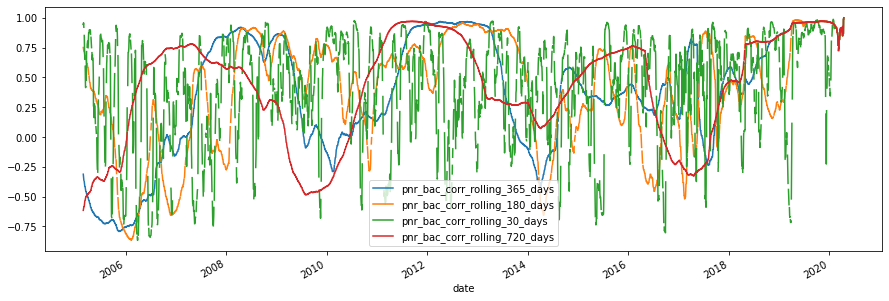

In [331]:
final_stock_df[['pnr_bac_corr_rolling_365_days','pnr_bac_corr_rolling_180_days', 
                                                'pnr_bac_corr_rolling_30_days', 'pnr_bac_corr_rolling_720_days']].plot(figsize=(15,5))

In [337]:
final_stock_df.columns

Index(['pnr_bac_corr_rolling_3_days', 'pnr_volume', 'bac_volume',
       'pnr_bac_corr_rolling_7_days', 'pnr_bac_corr_rolling_30_days',
       'pnr_bac_corr_rolling_180_days', 'pnr_bac_corr_rolling_365_days',
       'pnr_bac_corr_rolling_720_days'],
      dtype='object')

## Split into X and Y

In [344]:
final_stock_df = final_stock_df.dropna()

In [345]:
final_stock_df_X, final_stock_df_y = final_stock_df.loc[:, final_stock_df.columns != 'pnr_bac_corr_rolling_7_days'],  final_stock_df.pnr_bac_corr_rolling_7_days

In [346]:
final_stock_df_X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17543 entries, 2005-02-25 to 2020-04-16
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   pnr_bac_corr_rolling_3_days    17543 non-null  float64
 1   pnr_volume                     17543 non-null  float64
 2   bac_volume                     17543 non-null  float64
 3   pnr_bac_corr_rolling_30_days   17543 non-null  float64
 4   pnr_bac_corr_rolling_180_days  17543 non-null  float64
 5   pnr_bac_corr_rolling_365_days  17543 non-null  float64
 6   pnr_bac_corr_rolling_720_days  17543 non-null  float64
dtypes: float64(7)
memory usage: 1.1 MB


In [347]:
final_stock_df_y

date
2005-02-25   -0.449730
2005-02-28   -0.366235
2005-03-01    0.067429
2005-03-02    0.706662
2005-03-03    0.896342
                ...   
2020-04-09    0.925646
2020-04-13    0.871451
2020-04-14    0.989073
2020-04-15    0.989084
2020-04-16    1.000000
Name: pnr_bac_corr_rolling_7_days, Length: 17543, dtype: float64

## Train Test Split to predict correaltion over the next 7 days

In [ ]:
train_test_split()

In [354]:
datetime.timedelta(7)

datetime.timedelta(days=7)

In [404]:
rolling_window = 7
predicted_corr_7_days = []
rmse_corr_7_days = []

for date_idx, date in enumerate(list(final_stock_df.index)):
        
    # need to use the dates from the DF due to weekends
    train_dates = final_stock_df.index[:date_idx+1]
    # The test is the rolling 7-day corr looking back the past seven days
    # Therefore, the test_date should be seven dates ahead of the data we are training on
    test_date = final_stock_df.index[rolling_window+date_idx+1]
    
    

    
    if date_idx % 100 == 0:
        print(f"Train dates =  {train_dates}")
        print(F"Prediction date = {test_date}")
        
    train_df = final_stock_df[final_stock_df.index.isin(list(train_dates))]
    test_df = final_stock_df[final_stock_df.index == test_date]
    
    # TODO - search for the rolling 7-days column, don't hardcode
    X_train, y_train = train_df.loc[:, train_df.columns != 'pnr_bac_corr_rolling_7_days'],  train_df.pnr_bac_corr_rolling_7_days
    X_test, y_test = test_df.loc[:, test_df.columns != 'pnr_bac_corr_rolling_7_days'],  test_df.pnr_bac_corr_rolling_7_days

    gb = GradientBoostingRegressor()
    
    gb.fit(X_train, y_train)
    try:
        prediction = gb.predict(X_test)
    except Exception as e:
        print(e)
        print(X_test)
    predicted_corr_7_days.append(prediction)
    
    rmse_corr_7_days.append(np.sqrt(mean_squared_error(y_test, prediction)))
    if date_idx % 100 == 0:
        print('prediction = ', prediction)
        print('actual =', y_test.values)
        print('')
    

    

Train dates =  DatetimeIndex(['2005-02-25'], dtype='datetime64[ns]', name='date', freq=None)
Prediction date = 2005-03-09 00:00:00
prediction =  [-0.44972987]
actual = [0.96618208]

Train dates =  DatetimeIndex(['2005-02-25', '2005-02-28', '2005-03-01', '2005-03-02',
               '2005-03-03', '2005-03-04', '2005-03-07', '2005-03-08',
               '2005-03-09', '2005-03-10',
               ...
               '2005-07-07', '2005-07-08', '2005-07-11', '2005-07-12',
               '2005-07-13', '2005-07-14', '2005-07-15', '2005-07-18',
               '2005-07-19', '2005-07-20'],
              dtype='datetime64[ns]', name='date', length=101, freq=None)
Prediction date = 2005-08-01 00:00:00
prediction =  [0.38122194]
actual = [0.88623999]

Train dates =  DatetimeIndex(['2005-02-25', '2005-02-28', '2005-03-01', '2005-03-02',
               '2005-03-03', '2005-03-04', '2005-03-07', '2005-03-08',
               '2005-03-09', '2005-03-10',
               ...
               '2005-11-28', '20

KeyboardInterrupt: 